In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from importlib import reload
from time import time
import pickle
from copy import deepcopy
import re


import numpy as np
import scipy as sc
import pandas as pd
import torch
print(torch.cuda.is_available())

import models
import utils
import dre
import rna
import vae
import designers
import editdistance

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib_venn import venn2, venn2_circles
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('whitegrid')

True


2024-12-18 22:11:44.652991: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 22:11:44.653021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 22:11:44.654228: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 22:11:44.661211: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-18 22:11:46.372759: W tensorflow/comp

In [2]:
# load design names to test (copy from rna-selection-092424.ipynb)

# ----- build menu of design algorithm names -----
adalead_thresholds = [0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = np.arange(0.1, 0.91, 0.1)
dbas_ridge_quantiles = [0.1, 0.2]

pp_design_names = ['vae-ridge']
for q in cbas_dbas_quantiles:
    q = round(q, 2)
    pp_design_names.append(f'cbas-ridge-{q}t19')
    
for q in dbas_ridge_quantiles:
    q = round(q, 2)
    pp_design_names.append(f'dbas-ridge-{q}t19')
    
for model_name in ['ridge', 'ff', 'cnn']:
    
    # adalead
    for thresh in adalead_thresholds:
        thresh = round(thresh, 4)
        pp_design_names.append(f'adalead-{model_name}-{thresh}')
    
    # biswas
    for temp in biswas_temperatures:
        temp = round(temp, 4)
        pp_design_names.append(f'biswas-{model_name}-{temp}') 
    
    # PEX
    pp_design_names.append(f'pex-{model_name}') 
        
    if model_name != 'ridge':
        # cbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            pp_design_names.append(f'cbas-{model_name}-{q}')
        
        # dbas
        for q in cbas_dbas_quantiles:
            q = round(q, 2)
            pp_design_names.append(f'dbas-{model_name}-{q}')

In [4]:
train_fname = '/data/wongfanc/rna-models/traindata-nsd0.02-040324.npz'
design_pkl_fname = '/data/wongfanc/rna-results/designs-041124.pkl'

d = np.load(train_fname)
trainseqs_n = list(d['trainseq_n'])
ytrain_n = d['ytrain_n']
name2designdata = dre.prepare_name2designdata(
    design_pkl_fname,
    train_fname,
    intermediate_iter_threshold=0.1,
    verbose=True
)

Loaded 5000 training points from /data/wongfanc/rna-models/traindata-nsd0.02-040324.npz.

Removed dbas-ridge-0.3t0 designs.
Removed dbas-ridge-0.3t1 designs.
Removed dbas-ridge-0.3t2 designs.
Removed dbas-ridge-0.3t3 designs.
Removed dbas-ridge-0.3t4 designs.
Removed dbas-ridge-0.3t5 designs.
Removed dbas-ridge-0.3t6 designs.
Removed dbas-ridge-0.3t7 designs.
Removed dbas-ridge-0.3t8 designs.
Removed dbas-ridge-0.3t9 designs.
Removed dbas-ridge-0.3t10 designs.
Removed dbas-ridge-0.3t11 designs.
Removed dbas-ridge-0.3t12 designs.
Removed dbas-ridge-0.3t13 designs.
Removed dbas-ridge-0.3t14 designs.
Removed dbas-ridge-0.3t15 designs.
Removed dbas-ridge-0.3t16 designs.
Removed dbas-ridge-0.3t17 designs.
Removed dbas-ridge-0.3t18 designs.
Removed dbas-ridge-0.3t19 designs.
Removed dbas-ridge-0.4t0 designs.
Removed dbas-ridge-0.4t1 designs.
Removed dbas-ridge-0.4t2 designs.
Removed dbas-ridge-0.4t3 designs.
Removed dbas-ridge-0.4t4 designs.
Removed dbas-ridge-0.4t5 designs.
Removed dbas-rid

Iterations [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19] (interval 1) have mean consecutive diff in mean prediction of 0.001.
Iterations [1, 3, 5, 7, 9, 11, 13, 15, 17, 19] (interval 2) have mean consecutive diff in mean prediction of 0.001.
Iterations [2, 5, 8, 11, 14, 17, 19] (interval 3) have mean consecutive diff in mean prediction of 0.001.
Iterations [3, 7, 11, 15, 19] (interval 4) have mean consecutive diff in mean prediction of 0.001.
Iterations [4, 9, 14, 19] (interval 5) have mean consecutive diff in mean prediction of 0.001.
Iterations [5, 11, 17, 19] (interval 6) have mean consecutive diff in mean prediction of 0.000.
Iterations [6, 13, 19] (interval 7) have mean consecutive diff in mean prediction of 0.001.
Iterations [7, 15, 19] (interval 8) have mean consecutive diff in mean prediction of 0.001.
Iterations [8, 17, 19] (interval 9) have mean consecutive diff in mean prediction of 0.001.
Iterations [9, 19] (interval 10) have mean consecutive diff i

  Removed cbas-ridge-0.9t5
  Removed cbas-ridge-0.9t6
  Removed cbas-ridge-0.9t7
  Removed cbas-ridge-0.9t8
  Removed cbas-ridge-0.9t9
  Removed cbas-ridge-0.9t10
  Removed cbas-ridge-0.9t11
  Removed cbas-ridge-0.9t12
  Removed cbas-ridge-0.9t13
  Removed cbas-ridge-0.9t14
  Removed cbas-ridge-0.9t15
  Removed cbas-ridge-0.9t16
  Removed cbas-ridge-0.9t17
  Removed cbas-ridge-0.9t18
No design data for dbas-ridge-0.9t0, exiting MDRE select_intermediate_iterations.
Design names:
cbas-ridge-0.1t19
cbas-ridge-0.2t19
cbas-ridge-0.3t19
cbas-ridge-0.4t19
cbas-ridge-0.5t19
cbas-ridge-0.6t19
cbas-ridge-0.7t19
cbas-ridge-0.8t19
cbas-ridge-0.9t19
dbas-ridge-0.1t19
dbas-ridge-0.2t19
adalead-ridge-0.5
adalead-ridge-0.4
adalead-ridge-0.3
adalead-ridge-0.2
adalead-ridge-0.1
adalead-ridge-0.05
adalead-ridge-0.01
pex-ridge
adalead-ff-0.5
adalead-ff-0.4
adalead-ff-0.3
adalead-ff-0.2
adalead-ff-0.1
adalead-ff-0.05
adalead-ff-0.01
dbas-ff-0.1
dbas-ff-0.2
dbas-ff-0.3
dbas-ff-0.4
dbas-ff-0.5
dbas-ff-0.6
db

In [12]:
def get_average_pairwise_distance(seqs1, seqs2, n_pair: int = 10000):
    seq1_n = np.random.choice(seqs1, n_pair, replace=True)
    seq2_n = np.random.choice(seqs2, n_pair, replace=True)
    ed_n = np.array([editdistance.eval(s1, s2) for s1, s2 in zip(seq1_n, seq2_n)])
    return np.mean(ed_n)

def get_average_ed(seqs_n):
    ed_n = np.array([editdistance.eval(rna.RNABinding.SEEDS[3], seq) for seq in seqs_n])
    return np.mean(ed_n)

In [14]:
preded_Lx = []
for name in pp_design_names:
    designseq_n, _, designpred_n = name2designdata[name]
    ed = get_average_ed(designseq_n)
    preded_Lx.append([np.mean(designpred_n), ed])
preded_Lx = np.array(preded_Lx)

In [20]:
df = pd.DataFrame(preded_Lx, columns=['pred', 'ed'], index = pp_design_names)

In [55]:
trained_n = np.array([editdistance.eval(rna.RNABinding.SEEDS[3], seq) for seq in trainseqs_n])

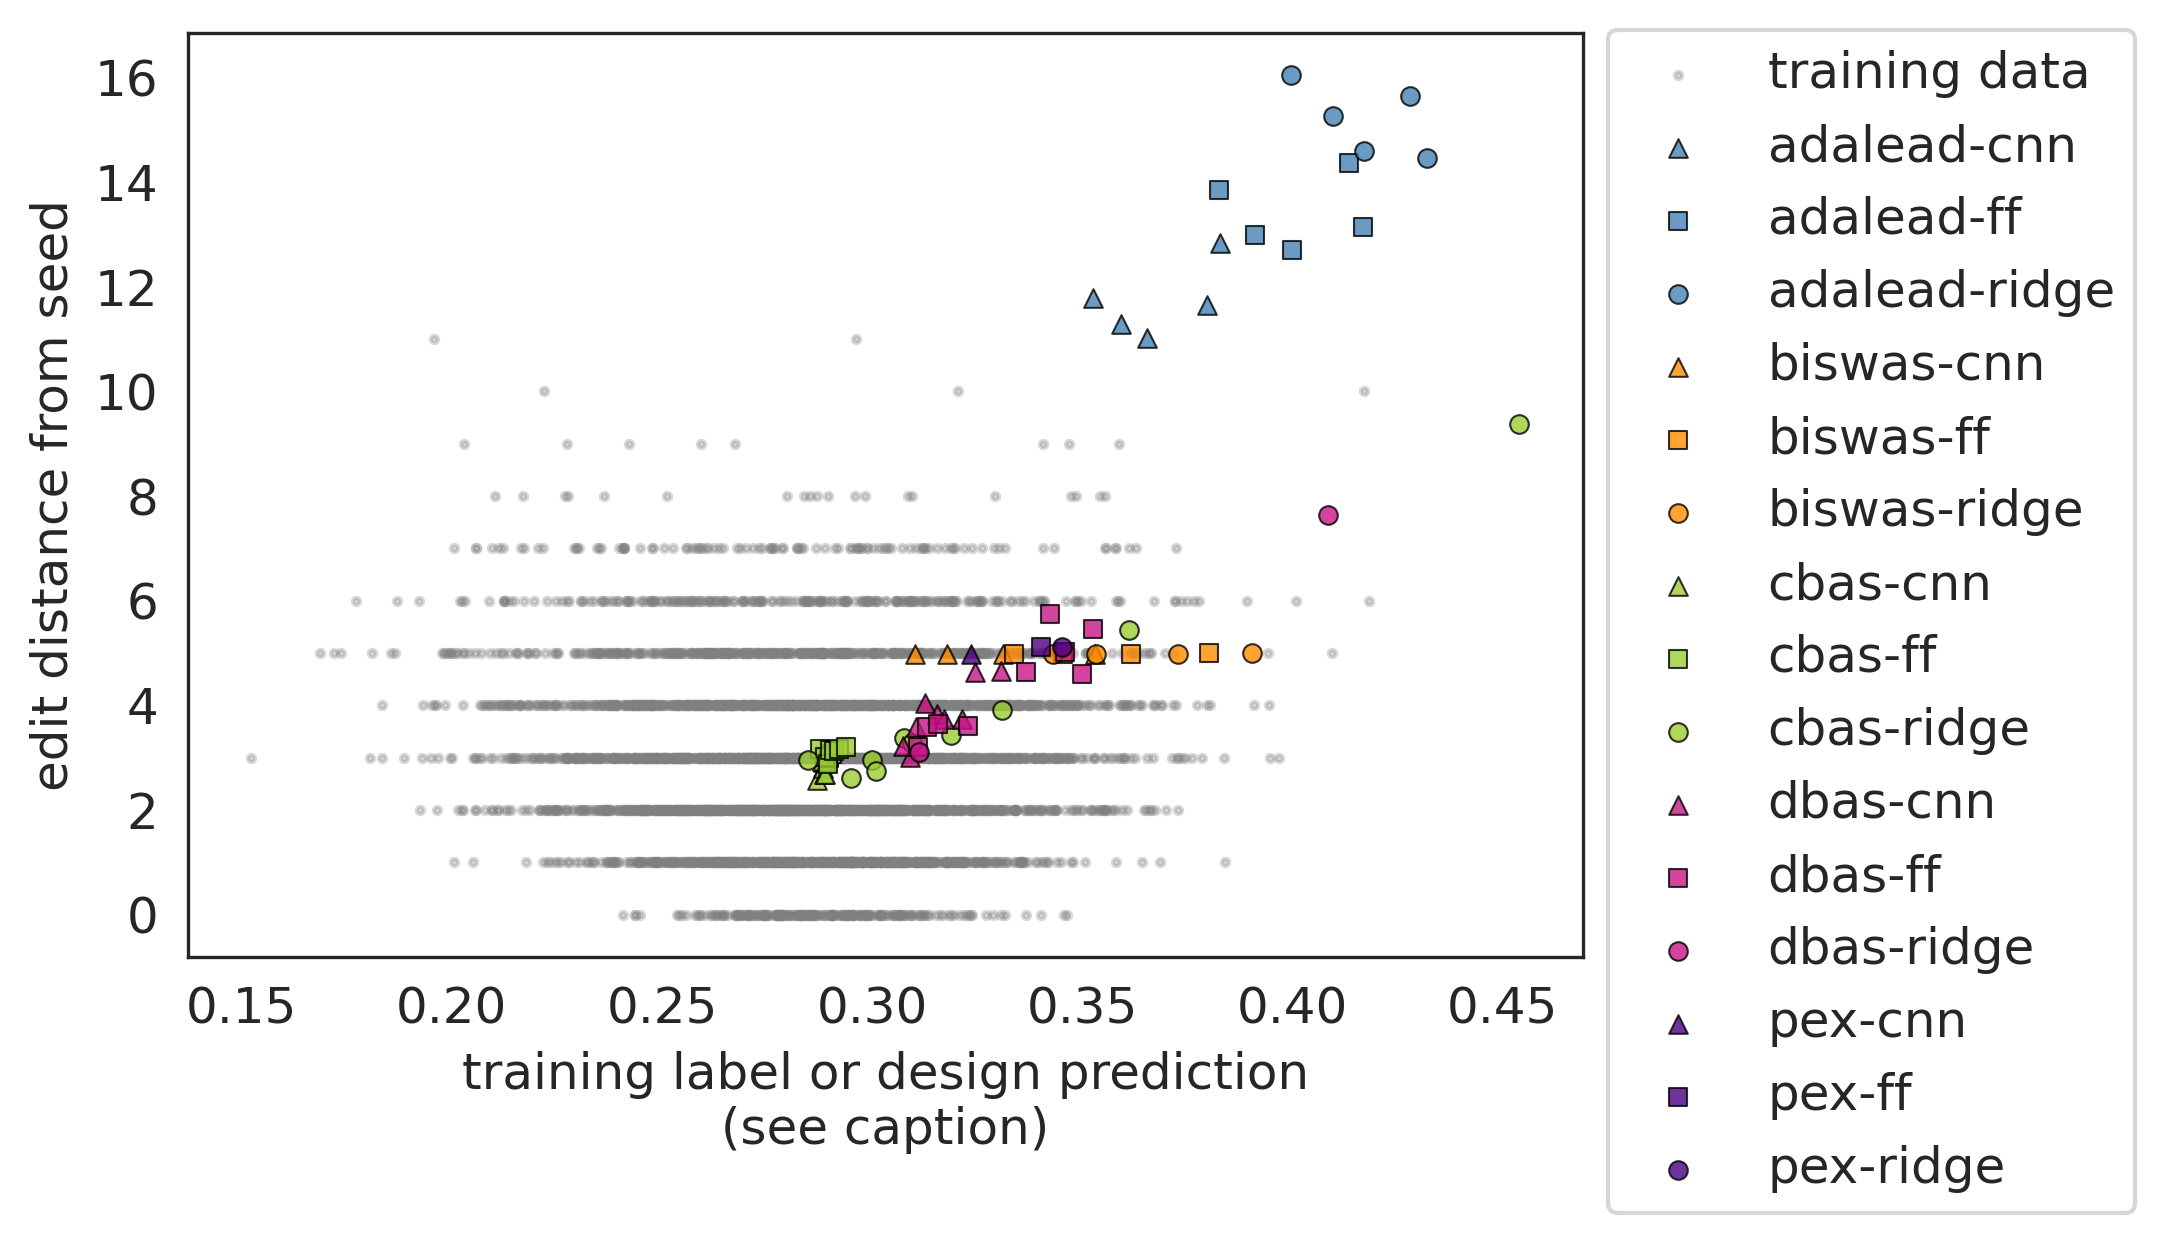

In [73]:
sns.set_style('white')
model2marker = {
    'ridge': 'o',
    'ff': 's',
    'cnn': '^'
}
name2color = {
    'adalead': 'steelblue',
    'biswas': 'darkorange',
    'cbas': 'yellowgreen',
    'dbas': 'mediumvioletred',
    'pex': 'indigo',
    'vae': 'yellowgreen',
}

def get_color_and_marker(name):
    for model, marker in model2marker.items():
        if model in name:
            break
            
    for da, color in name2color.items():
        if da in name:
            break
    legend_label = f'{da}-{model}'
    return color, marker, legend_label

plt.figure(figsize=(6, 4), dpi=300)
plt.scatter(ytrain_n, trained_n, s=3, alpha=0.3, c='gray', label='training data')
used_legend_labels = []
for name in pp_design_names:
    color, marker, legend_label = get_color_and_marker(name)
    if legend_label in used_legend_labels or name[: 3] == 'vae':
        label = None
    else:
        label = legend_label
    used_legend_labels.append(legend_label)
    plt.scatter(df.loc[name].pred, df.loc[name].ed,
                s=20, alpha=0.8, linewidth=0.5, edgecolor='k', marker=marker, c=color, label=label)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.03))
plt.xlabel('training label or design prediction\n(see caption)');
plt.ylabel('edit distance from seed');
# plt.yticks([])
# plt.xticks([])